# Deeplens implementation
In this notebook, some basic observations of the dataset generated by the deeplenstronomy wrapper are performed. To run this notebook, an installation of the deeplenstronomy wrapper is necessary.

## 1. Import

In [1]:
import numpy as np
import pandas as pd

import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image
from helpers import*
from deeplenshelpers import*

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

## 2. Dataset
The dataset is build with a '.yalm' file where all configurations are define. The models' parameters vary with an uniform distribution.

Lens' light parameters:
* Model : Sersic ellipse
* Amplitude : $amp = 22$
* Sersic radius : $R_{sersic} = 0.25$
* Sersic index : $n_{sersic}= 2.9$
* Ellipsity* : $e_1 = 0$   and   $e_2 = 0.09$
* Center : $x = 0$ and $y = 0$

Lens' mass variation :
- Model : Power-law Elliptical Mass Distribution

>$\kappa = \frac{3-\gamma }{2}\left ( \frac{\theta_E}{\sqrt{q e_1^2+ e_2^2/q}} \right )^{\gamma-1}$
 
* Einstein radius: $\theta_E \in [1, 2]$

* Power law slope: $\gamma \in [1.8, 2.2]$
* Ellipsity* : $e_1 \in [-0.18, 0.18]$   and $e_2 \in [0, 0.18]$
* Center : $x = 0$ and $y = 0$

Source variation :
* Model : Sersic ellipse
* Amplitude : $amp \in [10, 24]$
* Sersic radius : $R_{sersic} \in [0.1, 0.4]$
* Sersic index : $n_{sersic} \in [0.8, 5]$
* Ellipsity* : $e_1 \in [-0.18, 0.18]$   and $e_2 \in [0, 0.18]$
* Center : $x \in [-0.5,0.5]$ and $y \in [-0.5,0.5]$

Note* : The ellipsity range is determined with the following equations, where $q\in [0.7, 1]$ and $\phi \in[0, \pi/2]$

>$e_1 = \frac{1-q}{1+q}\cos{(2\phi)}$     and     $e_2 = \frac{1-q}{1+q}\sin{(2\phi)} $

In [2]:
config_file_name1 = 'data/configFile/config_model1.yaml' # Mass variation
dataset1 = dl.make_dataset(config_file_name1)

config_file_name2 = 'data/configFile/config_model2.yaml' # Source variation
dataset2 = dl.make_dataset(config_file_name2)

config_file_name3 = 'data/configFile/config_model3.yaml' # Mass & source variation
dataset3 = dl.make_dataset(config_file_name3)

In [3]:
dataset3.CONFIGURATION_1_metadata.drop(col_drop,axis=1).head()

,PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-WFC3_F160W,PLANE_1-OBJECT_1-MASS_PROFILE_1-gamma-WFC3_F160W,PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-WFC3_F160W,PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-WFC3_F160W,PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-WFC3_F160W,PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-WFC3_F160W,PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-WFC3_F160W,PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-WFC3_F160W
0,0.969303,2.166040,0.043564,-0.179818,0.183652,2.901711,0.225413,-0.302819
1,1.178131,1.929017,0.526256,0.120364,0.434155,3.303872,0.022226,0.025830
2,1.007642,1.982755,0.126845,0.162131,0.572309,4.158008,-0.271295,-0.092726
3,1.085961,1.790253,0.312898,0.142541,0.461902,2.493481,-0.117323,-0.296371
4,1.089506,2.212913,0.022888,-0.004391,0.212066,1.442297,-0.093102,0.046742


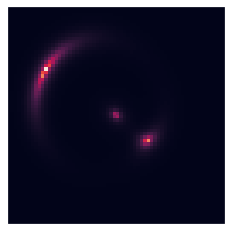

In [4]:
view_image(dataset2.CONFIGURATION_1_images[9][0]) # image without noise

In [5]:
# Build the four classes 
config_repo_model = 'data/configFile/config_model'


for i in np.arange(1,4):
    model_name = config_repo_model + str(i) + '.yaml'
    res = ResidualDeepLens(model_name)
    res.build(i)
print('Data Generation Finished')

Data Generation Finished


In [6]:
metadata = pd.DataFrame()
for i in np.arange(1,4):
    [img, meta] = read_hdf5(str(i), path = "data/dataSet/")
    metadata = pd.concat([metadata,meta], ignore_index=True)
    if i == 1:
        final_array = img
    else:
         final_array = np.concatenate((final_array, img))
metadata ['ID'] = np.arange(0,final_array.shape[0])

print('Reading Data Finished')

Reading Data Finished


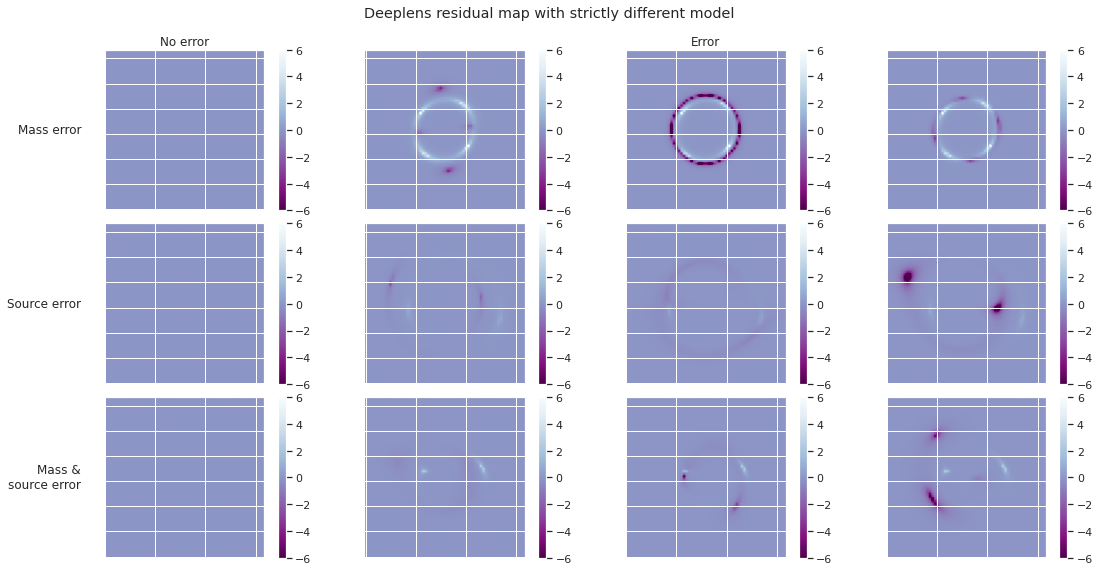

In [7]:
f, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=False, sharey=False)
norm = colors.Normalize(vmin=-6, vmax=6)

for i in range(0,4):
    pos1 = axes[0,i].imshow(final_array[i,0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
    pos2 = axes[1,i].imshow(final_array[40+i,0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
    pos3 = axes[2,i].imshow(final_array[80+i,0,:,:], vmin=-6, vmax=6, origin='lower',cmap=plt.cm.BuPu_r)
    axes[0,i].set_yticklabels([]); axes[0,i].set_xticklabels([])
    axes[1,i].set_yticklabels([]); axes[1,i].set_xticklabels([])
    axes[2,i].set_yticklabels([]); axes[2,i].set_xticklabels([])
    f.colorbar(pos1, ax=axes[0,i])
    f.colorbar(pos2, ax=axes[1,i])
    f.colorbar(pos3, ax=axes[2,i])
pad = 5
axes[0,0].annotate('No error', xy=(0.5, 1), xytext=(0, pad),
                   xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline')
axes[0,2].annotate('Error', xy=(0.5, 1), xytext=(0, pad),
                   xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline')

axes[0,0].annotate('Mass error', xy=(0, 0.5), xytext=(-axes[0,0].yaxis.labelpad - pad, 0),
                   xycoords=axes[0,0].yaxis.label, textcoords='offset points', ha='right', va='center')
axes[1,0].annotate('Source error', xy=(0, 0.5), xytext=(-axes[1,0].yaxis.labelpad - pad, 0),
                   xycoords=axes[1,0].yaxis.label, textcoords='offset points', ha='right', va='center')
axes[2,0].annotate('Mass &\nsource error', xy=(0, 0.5), xytext=(-axes[2,0].yaxis.labelpad - pad, 0),
                   xycoords=axes[2,0].yaxis.label, textcoords='offset points', ha='right', va='center')

f.suptitle('Deeplens residual map with strictly different model', size = 'large')
f.tight_layout()
plt.show()

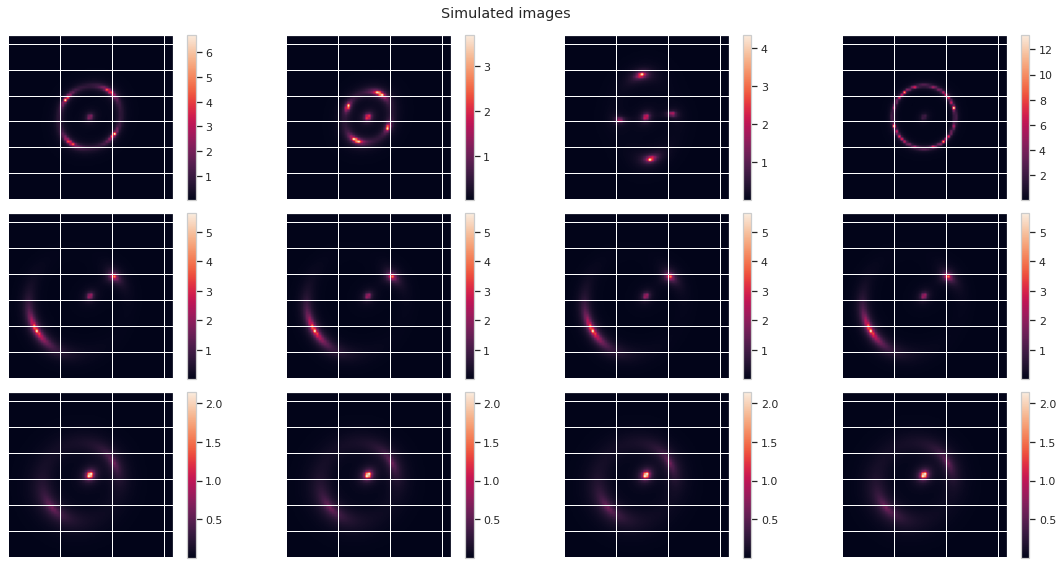

In [8]:
f, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=False, sharey=False)
norm = colors.Normalize(vmin=-6, vmax=6)
config_file_name1 = 'data/configFile/config_model1.yaml' # Mass variation
dataset1 = dl.make_dataset(config_file_name1)

config_file_name2 = 'data/configFile/config_model2.yaml' # Source variation
dataset2 = dl.make_dataset(config_file_name2)

config_file_name3 = 'data/configFile/config_model3.yaml' # Mass & source variation
dataset3 = dl.make_dataset(config_file_name3)
p_decal = 10
sns.set_theme(style="whitegrid")

for i in range(0,4):
    image_real = dataset1.CONFIGURATION_1_images[i][0]
    pos1 = axes[0,i].imshow(image_real, origin='lower')
    image_real = dataset2.CONFIGURATION_1_images[9][0]
    pos2 = axes[1,i].imshow(image_real, origin='lower')
    image_real = dataset3.CONFIGURATION_1_images[9][0]
    pos3 = axes[2,i].imshow(image_real, origin='lower')
    axes[0,i].set_yticklabels([]); axes[0,i].set_xticklabels([])
    axes[1,i].set_yticklabels([]); axes[1,i].set_xticklabels([])
    axes[2,i].set_yticklabels([]); axes[2,i].set_xticklabels([])
    f.colorbar(pos1, ax=axes[0,i])
    f.colorbar(pos2, ax=axes[1,i])
    f.colorbar(pos3, ax=axes[2,i])

f.suptitle('Simulated images', size = 'large')
f.tight_layout()
plt.show()

plt.show()